<a href="https://colab.research.google.com/github/ashleyngomez380/CSCI-6377/blob/main/Cluster_1(16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import random
import csv
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.optim as optim


In [65]:
# For reproducibility
torch.manual_seed(6379)
torch.cuda.manual_seed(6379)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [66]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [67]:
# Hyper-parameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip()])



In [68]:
#Train Data Set
url_train = "https://hpc.utrgv.edu/static/data/sedan_vs_pickup/train.csv"
train_df = pd.read_csv(url_train)



In [69]:
# Assuming the first and last column are the ID and label
X = train_df.iloc[:, 1:-1].values
y = train_df.iloc[:, -1].values

In [70]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X)
y_train_tensor = torch.LongTensor(y)  # Use LongTensor for classification labels

# Convert your data to tensors before passing to the dataset
X_train_tensor = X_train_tensor.float()  # Assuming X_train_tensor is your input data tensor
y_train_tensor = y_train_tensor.long()   # Assuming y_train_tensor is your label tensor




In [71]:
# Create a Dataset Class
class CustomDataset_Train(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data  # Assuming data represents inputs or samples
        self.targets = targets  # Assuming targets represents labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample, label = self.data[index], self.targets[index]  # Fix attribute name to `targets`
        if self.transform:
            sample = self.transform(sample)
        return sample, label



In [72]:
# Creating dataset with transformations
dataset = CustomDataset_Train(X_train_tensor, y_train_tensor)


# Loading
# DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

#Test Data Set
url_test = "https://hpc.utrgv.edu/static/data/sedan_vs_pickup/test.csv"
test_df = pd.read_csv(url_test)


In [73]:
print(X.shape)
print(X.dtype)

(1020, 65536)
int64


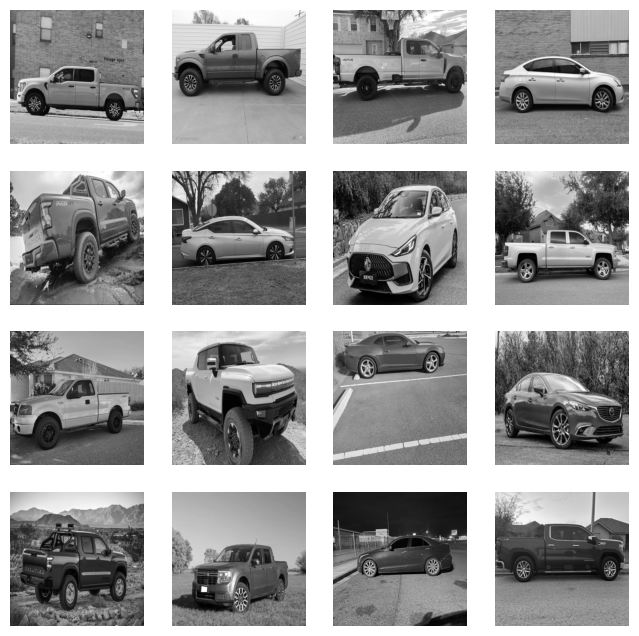

In [74]:
num_rows = min(16, X.shape[0])

# Display the images
plt.figure(figsize=(8, 8))
for i in range(num_rows):
    plt.subplot(4, 4, i + 1)  # Adjust subplot layout as needed
    img = images[i].reshape(256, 256)  # Reshape the flattened image to its original shape
    plt.imshow(img, cmap='gray')  # Assuming grayscale images
    plt.axis('off')
plt.show()


In [75]:
# Creating convolution Network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*64*64, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten the feature maps
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [76]:
model = ConvNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [77]:
# Input Output
inputs = torch.randn(32, 1, 256, 256)
outputs = model(inputs)
print(outputs.shape)  # Check the output shape

torch.Size([32, 2])


In [78]:
# Reshape images to [batch_size, channels, height, width]
images = images.view(-1, 1, 256, 256)

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# n_total_steps = len(train_loader)
for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        images = images.view(-1, 1, 256, 256)
        labels = labels.to(device)

        #Clearing
        optimizer.zero_grad()

        #Foward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize

        loss.backward()
        optimizer.step()


        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

[1] loss: 348.314
[2] loss: 0.577
[3] loss: 0.417
[4] loss: 0.272
[5] loss: 0.149
[6] loss: 0.056
[7] loss: 0.035
[8] loss: 0.014
[9] loss: 0.007
[10] loss: 0.003


In [81]:
torch.save(model, 'model.pth')

In [89]:
model = torch.load('model.pth')

In [90]:
url_test = "https://hpc.utrgv.edu/static/data/sedan_vs_pickup/test.csv"
test_df = pd.read_csv(url_test)

In [91]:
X_test = test_df.values
IDs = X_test[:, 0]
X_test_tensor = torch.FloatTensor(X_test[:, 1:])
X_test_tensor = X_test_tensor.view(-1, 1, 256, 256)

In [92]:
# Set the model to evaluation mode
model.eval()

predictions = []
index = 0
# Disable gradient computation for efficiency
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

    index += 1
predicted = predicted.numpy()

In [93]:
predictions = np.dstack((IDs, predicted))[0]
with open('submission_17.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(['ID','Class'])
    write.writerows(predictions)